<a href="https://colab.research.google.com/github/graviada/colabRepo/blob/master/2022/TorchML%20(6%2C%202022)/Lab2/PyTorch_Lab2_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Импортируем основные модули pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch.utils.data import DataLoader

# Импортируем модули, связанные с компьютерным зрением
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

# Импортируем вспомогательные модули
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import random

In [ ]:
def randomSet():
  # random.seed(0)
  np.random.seed(0)
  torch.manual_seed(0)
  torch.cuda.manual_seed(0)
  # torch.backends.cudnn.deterministic = True

In [ ]:
# Если графический ускоритель поддерживает обучение на нем, будем использовать его,
# иначе обучать на процессоре.
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# Для воспроизводимости результатов обучения нейронной сети
randomSet()

In [ ]:
# В данной лабораторной работе вам необходимо обучить две сети с архитектурой,
# которую вам необходимо разработать самостоятельно.
# В этой части предлагается реализовать полносвязную сеть без использования сверточных слоев.
# Поэкспериментируйте с использованием слоев пакетной нормализации и дропаута.
# Сравните точность на тестовой выборке с аналогичными результатами одногруппников.
class FCNet(nn.Module):

    def __init__(self, input_size=32*32*3, output_size=10):
        super().__init__()
        print(input_size)
        self.fc1 = nn.Linear(input_size, 512)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(512, 1024)
        self.act2 = nn.ReLU()
        # self.dropout = nn.Dropout(p=0.6)
        self.fc3 = nn.Linear(1024, 128)
        self.batchnorm1 = nn.BatchNorm1d(128)
        self.act3 = nn.ReLU()
        self.fc4 = nn.Linear(128, 32)
        self.batchnorm2 = nn.BatchNorm1d(32)
        self.act4 = nn.ReLU()
        self.fc5 = nn.Linear(32, output_size)

    def forward(self, x):
        # x = torch.flatten(x, start_dim=3)
        x = self.act1(self.fc1(x))
        x = self.act2(self.fc2(x))
        # x = self.dropout(x)
        x = self.act3(self.batchnorm1(self.fc3(x)))
        x = self.act4(self.batchnorm2(self.fc4(x)))
        x = self.fc5(x)

        return x

In [ ]:
# Задаем количество эпох (проходов по всей обучающей выборке) и размер пакета, можно варьировать
EPOCHS = 15
BATCH_SIZE = 256

In [ ]:
# Второй шаг используется для нормализации данных путем указания среднего значения и
# стандартного отклонения для каждого из трех каналов
# Это преобразует данные из [0,1] в [-1,1]

# Нормализация данных должна помочь ускорить преобразование и уменьшить вероятность
# исчезновения градиентов с определенными функциями активации
transform_ = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Загружаем данные из набора CIFAR10
train_data = datasets.CIFAR10(root='./data/train', train=True, download=True, transform=transform_)
test_data = datasets.CIFAR10(root='./data/test', train=False, download=True, transform=transform_)

# DataLoader позволяет разбить выборку на пакеты заданного размера.
# Параметр shuffle отвечает за перемешивание данных в пакете
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/train/cifar-10-python.tar.gz to ./data/train


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/test/cifar-10-python.tar.gz to ./data/test


In [ ]:
'''
def convert_to_imshow_format(image):
    # first convert back to [0,1] range from [-1,1] range
    image = image / 2 + 0.5
    image = image.numpy()
    # convert from CHW to HWC
    # from 3x32x32 to 32x32x3
    return image.transpose(1,2,0)

train_data_loader = DataLoader(train_data, batch_size=len(train_data))
images, labels = next(iter(train_data_loader))

# dataiter = iter(trainloader)
# images, labels = dataiter.next()

fig, axes = plt.subplots(1, len(images), figsize=(12,2.5))
for idx, image in enumerate(images):
    axes[idx].imshow(convert_to_imshow_format(image))
    axes[idx].set_title(classes[labels[idx]])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])
'''

'\ndef convert_to_imshow_format(image):\n    # first convert back to [0,1] range from [-1,1] range\n    image = image / 2 + 0.5\n    image = image.numpy()\n    # convert from CHW to HWC\n    # from 3x32x32 to 32x32x3\n    return image.transpose(1,2,0)\n\ntrain_data_loader = DataLoader(train_data, batch_size=len(train_data))\nimages, labels = next(iter(train_data_loader))\n\n# dataiter = iter(trainloader)\n# images, labels = dataiter.next()\n\nfig, axes = plt.subplots(1, len(images), figsize=(12,2.5))\nfor idx, image in enumerate(images):\n    axes[idx].imshow(convert_to_imshow_format(image))\n    axes[idx].set_title(classes[labels[idx]])\n    axes[idx].set_xticks([])\n    axes[idx].set_yticks([])\n'

In [ ]:
# Готовимся к обучению
model = FCNet().to(device)  # создаем модель
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)  # оптимизатор, нужно выбрать и настроить
loss_function = nn.CrossEntropyLoss()  # функция потерь, нужно выбрать
loss_history = list()  # список для хранения истории изменения функции стоимости

3072


In [ ]:
# Начинаем обучение
for epoch in range(EPOCHS):
    for i, (batch, labels) in enumerate(train_loader):  # разбиваем выборку на пакеты
        # Нужно реализовать один шаг градиентного спуска
        batch = batch.reshape(batch.shape[0], -1).to(device)
        loss = torch.tensor(0, dtype=torch.float32)  # значение функции стоимости на пакете, нужно рассчитать
        # ВАШ КОД ЗДЕСЬ
        optimizer.zero_grad()
        loss = loss_function(model(batch), labels.to(device))
        loss.backward()
        optimizer.step()
        loss_history.append(loss.log().item())  # добавляется логарифм стоимости для большей наглядности
    print(f'Эпоха {epoch + 1} завершилась с функцией стоимости на последнем пакете = {loss.item()}')

Эпоха 1 завершилась с функцией стоимости на последнем пакете = 1.599491000175476
Эпоха 2 завершилась с функцией стоимости на последнем пакете = 1.5764954090118408
Эпоха 3 завершилась с функцией стоимости на последнем пакете = 1.5583852529525757
Эпоха 4 завершилась с функцией стоимости на последнем пакете = 1.3676543235778809
Эпоха 5 завершилась с функцией стоимости на последнем пакете = 1.264444351196289
Эпоха 6 завершилась с функцией стоимости на последнем пакете = 1.1549632549285889
Эпоха 7 завершилась с функцией стоимости на последнем пакете = 1.1110236644744873
Эпоха 8 завершилась с функцией стоимости на последнем пакете = 1.078973650932312
Эпоха 9 завершилась с функцией стоимости на последнем пакете = 0.9528512954711914
Эпоха 10 завершилась с функцией стоимости на последнем пакете = 0.9556400179862976
Эпоха 11 завершилась с функцией стоимости на последнем пакете = 0.69871985912323
Эпоха 12 завершилась с функцией стоимости на последнем пакете = 0.42164936661720276
Эпоха 13 завершил

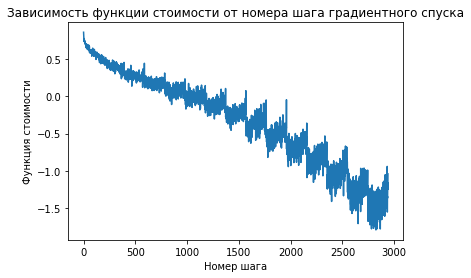

In [ ]:
# Выводим график функции стоимости
plt.title('Зависимость функции стоимости от номера шага градиентного спуска')
plt.xlabel('Номер шага')
plt.ylabel('Функция стоимости')
plt.plot(loss_history)
plt.show()

In [ ]:
# Отключаем расчет вычислительного графа для экономии времени и памяти: нам не нужно считать градиенты при тестировании модели
with torch.no_grad():
    # Оцениваем качество модели
    train_data_loader = DataLoader(train_data, batch_size=len(train_data))
    train_features, train_targets = next(iter(train_data_loader))

    train_features = train_features.to(device)
    train_features = train_features.reshape(train_features.shape[0], -1).to(device)
    train_model_predictions = torch.argmax(model(train_features), dim=1)
    print('Точность (accuracy) на обучающей выборке:', accuracy_score(train_data.targets, train_model_predictions))

    test_data_loader = DataLoader(test_data, batch_size=len(test_data))
    test_features, test_targets = next(iter(test_data_loader))

    test_features = test_features.to(device)
    test_features = test_features.reshape(test_features.shape[0], -1).to(device)
    test_model_predictions = torch.argmax(model(test_features), dim=1)
    print('Точность (accuracy) на тестовой выборке:', accuracy_score(test_data.targets, test_model_predictions))

Точность (accuracy) на обучающей выборке: 0.94468
Точность (accuracy) на тестовой выборке: 0.5498
